In [1]:
import gym
from collections import defaultdict

import inline as inline
import matplotlib
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# init gym environment
env = gym.make('Blackjack-v1')


# define policy to hit until 19 (0=stand, 1=hit)
def hit_til_19(observation):
    score, dealer_score, ace = observation
    return 0 if score >= 19 else 1


# define method to generate data for an episode
def generate_episode_data(policy, env):
    # init the lists to store states, actions, and rewards
    states, actions, rewards = [], [], []

    # reset gym environment
    observation = env.reset()

    while True:
        # add the states to resp. list
        states.append(observation)
        # select action based on policy
        action = hit_til_19(observation)
        # append to actions list
        actions.append(action)
        # perform action in environment
        observation, reward, done, info = env.step(action)
        # add the reward to rewards list
        # print(reward)
        rewards.append(reward)
        # break if state is terminal
        if done:
            break
    return states, actions, rewards

In [3]:
# define first-visit mc prediction function
def fv_mc_prediction(policy, env, n_episodes):
    # init the empty value table - dictionary to store values of each state
    value_table = defaultdict(float)
    N = defaultdict(int)

    # for each episode generate data and store
    for _ in range(n_episodes):
        # generate & store data
        data = generate_episode_data(policy, env)
        returns = 0
        if data is not None:
            # for each step store rewards and states to temp variable and calculate returns as sum of rewards
            # for each episode calculate current value of all the states involved (starting from terminal state)
            for i in range(len(data[0]) - 1, -1, -1):
                _reward = data[2][i]
                _state = data[0][i]

                # add reward to returns
                returns += _reward
                # for first-visit check if episode is visited for the first time
                if _state not in data[0][:i]:
                    # if yes standard mc incremental equation
                    # NewEstimate = OldEstimate + StepSize(Target-OldEstimate)
                    N[_state] += 1
                    value_table[_state] += (returns - value_table[_state]) / N[_state]
            # print(returns)
    return value_table


prediction = fv_mc_prediction(hit_til_19, env, n_episodes=500000)


for j in range(10):
    print(prediction.popitem()) 

((12, 6, True), -1.474514954580286e-17)
((12, 7, True), -0.08928571428571427)
((15, 9, True), -0.20599250936329577)
((4, 5, False), -0.349056603773585)
((12, 3, True), 0.013392857142857095)
((14, 6, True), -0.08447937131630648)
((16, 9, True), -0.19587628865979403)
((17, 8, True), -0.18181818181818193)
((13, 2, True), -0.05208333333333339)
((19, 2, True), 0.407720144752714)


In [4]:
# define function to plot blackjack results
def plot_blackjack(p, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_sum = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_sum), len(usable_ace)))
    # loop through player_sum values
    for i, player in enumerate(player_sum):
        # loop through dealer_sum values
        for j, dealer in enumerate(dealer_sum):
            # loop through usable_ace values
            for k, ace in enumerate(usable_ace):
                # create state_value
                state_values[i, j, k] = p[player, dealer, ace]

    # X, Y coordinates from player and dealer sums
    X, Y = np.meshgrid(player_sum, dealer_sum)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])

    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player_sum')
        ax.set_xlabel('dealer_sum')
        ax.set_zlabel('state_value')
  

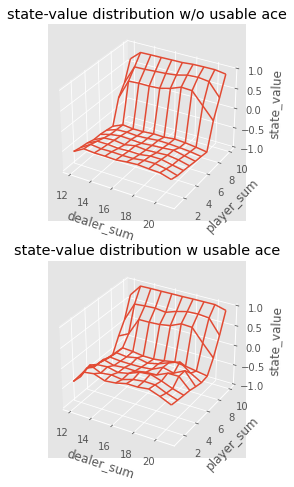

In [5]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8), subplot_kw={'projection': '3d'})

axes[0].set_title('state-value distribution w/o usable ace')
axes[1].set_title('state-value distribution w usable ace')
plot_blackjack(prediction, axes[0], axes[1])